# Complex Dataset with  CausalML Meta-learners

Run Times for 400k dev set with 100k holdout

S Learner LGBM 8s

S Learner XGB 38s

T Learner LR 6s

T Learner SDG 4:50

T Learner LGBM 8s

T Learner XGB 37

X Learner LGBM 6:36:29

X Learner XGB 9:24:19s

Pylift randomized XGB search 100 iterations CV 5 24 hours

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
import warnings

import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor, BaseXClassifier
from causalml.inference.nn import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *


from sklift.metrics import auqc, auuc, uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves
import seaborn as sns
sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
Using TensorFlow backend.


In [2]:
filepath = '/nas/isg_prodops_work/stemr/2020/2020_03 - Capstone Project/'
complex_df = pd.read_pickle(filepath + 'complex_df_kitchensink.pkl')
complex_df['segments'] = complex_df['segments'].astype('str')
cat_columns = complex_df.select_dtypes(['category']).columns
complex_df[cat_columns] = complex_df[cat_columns].apply(lambda x: x.cat.codes)

In [3]:
#holdout for final performance eval
dev_df, holdout_df = train_test_split(complex_df, test_size=0.05)

In [15]:
holdout_df.shape

(100000, 329)

In [16]:
holdout_df = holdout_df.reset_index(drop=True)

In [17]:
dev_df = dev_df.sample(400000)

In [18]:
dev_df.shape

(400000, 329)

In [19]:
feature_names = list(pd.read_csv(filepath + 'complex_df_feat_names.csv')['feature'])
target_name = 'conversion_post'
treatment_name = 'exposed'

In [20]:
x_train = dev_df[feature_names]
y_train = dev_df[target_name]
t_train = dev_df[treatment_name]

In [21]:
x_train.shape

(400000, 149)

In [36]:
#S Learner Light GBM
learner_s = BaseSRegressor(learner=LGBMRegressor(n_jobs=10))
learner_s.fit(X=x_train, treatment=t_train, y=y_train)
S_lgbm_pred = learner_s.predict(holdout_df[feature_names]).flatten()

In [35]:
#S Learner XGB
learner_s = BaseSRegressor(learner=XGBRegressor(n_jobs=10))
learner_s.fit(X=x_train, treatment=t_train, y=y_train)
s_xgb_pred = learner_s.predict(holdout_df[feature_names]).flatten()

[11:00:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
#T Learner Linear Regression
learner_t = BaseTRegressor(learner=LinearRegression(normalize=True))
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_lr_pred = learner_t.predict(holdout_df[feature_names]).flatten()

In [25]:
#T Learner SDG
learner_t = BaseTRegressor(learner=SGDRegressor(max_iter=1000, tol=1e-3))
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_sdg_pred = learner_t.predict(holdout_df[feature_names]).flatten()

In [26]:
#T Learner Light GBM
learner_t = BaseTRegressor(learner=LGBMRegressor(n_jobs=10))
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_lgbm_pred = learner_t.predict(holdout_df[feature_names]).flatten()

In [27]:
#T Learner XGB
learner_t = BaseTRegressor(learner=XGBRegressor(n_jobs=10))
learner_t.fit(X=x_train, treatment=t_train, y=y_train)
t_xgb_pred = learner_t.predict(holdout_df[feature_names]).flatten()

[18:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
#X Learner light gbm
learner_x = BaseXRegressor(learner=LGBMRegressor(n_jobs=10))
learner_x.fit(X=x_train, treatment=t_train, y=y_train)
x_lgbm_pred = learner_x.predict(holdout_df[feature_names]).flatten()

In [29]:
#X Learner XGB
learner_x = BaseXRegressor(learner=XGBRegressor(n_jobs=10))
learner_x.fit(X=x_train, treatment=t_train, y=y_train)
x_xgb_pred = learner_x.predict(holdout_df[feature_names]).flatten()

[10:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
important_columns = feature_names + ['exposed','true_lift','conversion_post', 'segments']

In [45]:
pred_df = pd.merge(holdout_df[import_columns],pd.DataFrame(S_lgbm_pred, columns=['S_LGBM']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(s_xgb_pred, columns=['S_XGB']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_lr_pred, columns=['T_LR']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_sdg_pred, columns=['T_SDG']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_lgbm_pred, columns=['T_LGBM']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(t_xgb_pred, columns=['T_XGB']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(x_lgbm_pred, columns=['X_LGBM']), left_index=True, right_index=True) 
pred_df = pd.merge(pred_df,pd.DataFrame(x_xgb_pred, columns=['X_XGB']), left_index=True, right_index=True) 
pred_df['random_prediction'] = pd.DataFrame(np.random.uniform(-1,1,len(pred_df['conversion_post'])))

In [46]:
pred_df.head(10)

,feature_172,feature_181,feature_176,feature_166,feature_168,feature_157,feature_150,feature_167,feature_144,feature_160,...,segments,S_LGBM,S_XGB,T_LR,T_SDG,T_LGBM,T_XGB,X_LGBM,X_XGB,random_prediction
0,-0.74,0.28,0.21,-0.06,-0.85,-0.57,-0.06,0.26,0.07,0.03,...,lost_cause,0.01,0.03,0.02,1680273258814303.25,-0.02,0.02,-0.00,0.03,-0.69
1,-2.37,0.28,-0.19,-0.36,-0.64,0.13,0.18,-2.12,-1.36,-0.80,...,lost_cause,0.00,0.03,-0.10,1265974269102753.25,-0.03,-0.02,-0.05,-0.00,-0.80
2,1.34,-1.02,0.26,-0.85,0.91,-1.03,0.76,-0.13,0.10,-0.23,...,persuadable,0.08,0.07,0.10,1288999763635742.00,0.11,0.11,0.12,0.09,0.36
3,0.20,-0.44,-1.21,0.14,0.84,-0.78,-0.28,-1.22,0.19,-0.53,...,lost_cause,0.06,0.04,0.06,1490100205738880.00,0.02,0.03,0.01,0.04,0.36
4,-0.24,0.10,-0.53,0.41,-0.52,0.32,-1.06,0.26,1.20,-1.50,...,lost_cause,0.11,0.08,0.12,479258322218528.50,0.12,0.13,0.08,0.09,-0.01
5,1.12,0.65,-0.08,-0.19,1.08,-0.04,-1.01,-0.25,0.03,-0.18,...,lost_cause,0.13,0.09,0.28,1036094270552873.50,-0.03,0.16,0.26,0.14,-0.68
6,-0.22,0.03,-0.53,0.83,-0.82,1.00,0.00,0.28,0.18,-1.03,...,lost_cause,0.07,0.05,0.06,2024116318680992.25,0.06,0.08,0.07,0.07,0.87
7,0.89,0.21,-0.52,0.18,0.27,-0.65,0.87,-0.46,-0.44,-0.13,...,lost_cause,0.09,0.07,0.10,638067136248323.38,0.08,0.06,0.07,0.09,-0.07
8,0.40,0.01,0.79,0.41,-1.14,0.67,-0.25,1.71,-1.18,-0.27,...,lost_cause,0.06,0.08,0.07,1407877637635219.00,0.05,0.07,0.06,0.09,0.20
9,0.80,-2.21,0.68,-0.54,1.04,0.22,-0.95,0.59,0.56,1.12,...,lost_cause,0.07,0.08,0.08,1669522563500850.50,0.04,0.07,0.08,0.09,0.24


In [ ]:
pred_df.to_csv(filepath + 'complex_predictions_final.csv',index=False)

In [6]:
pred_df = pd.read_csv(filepath + 'complex_predictions_final.csv')

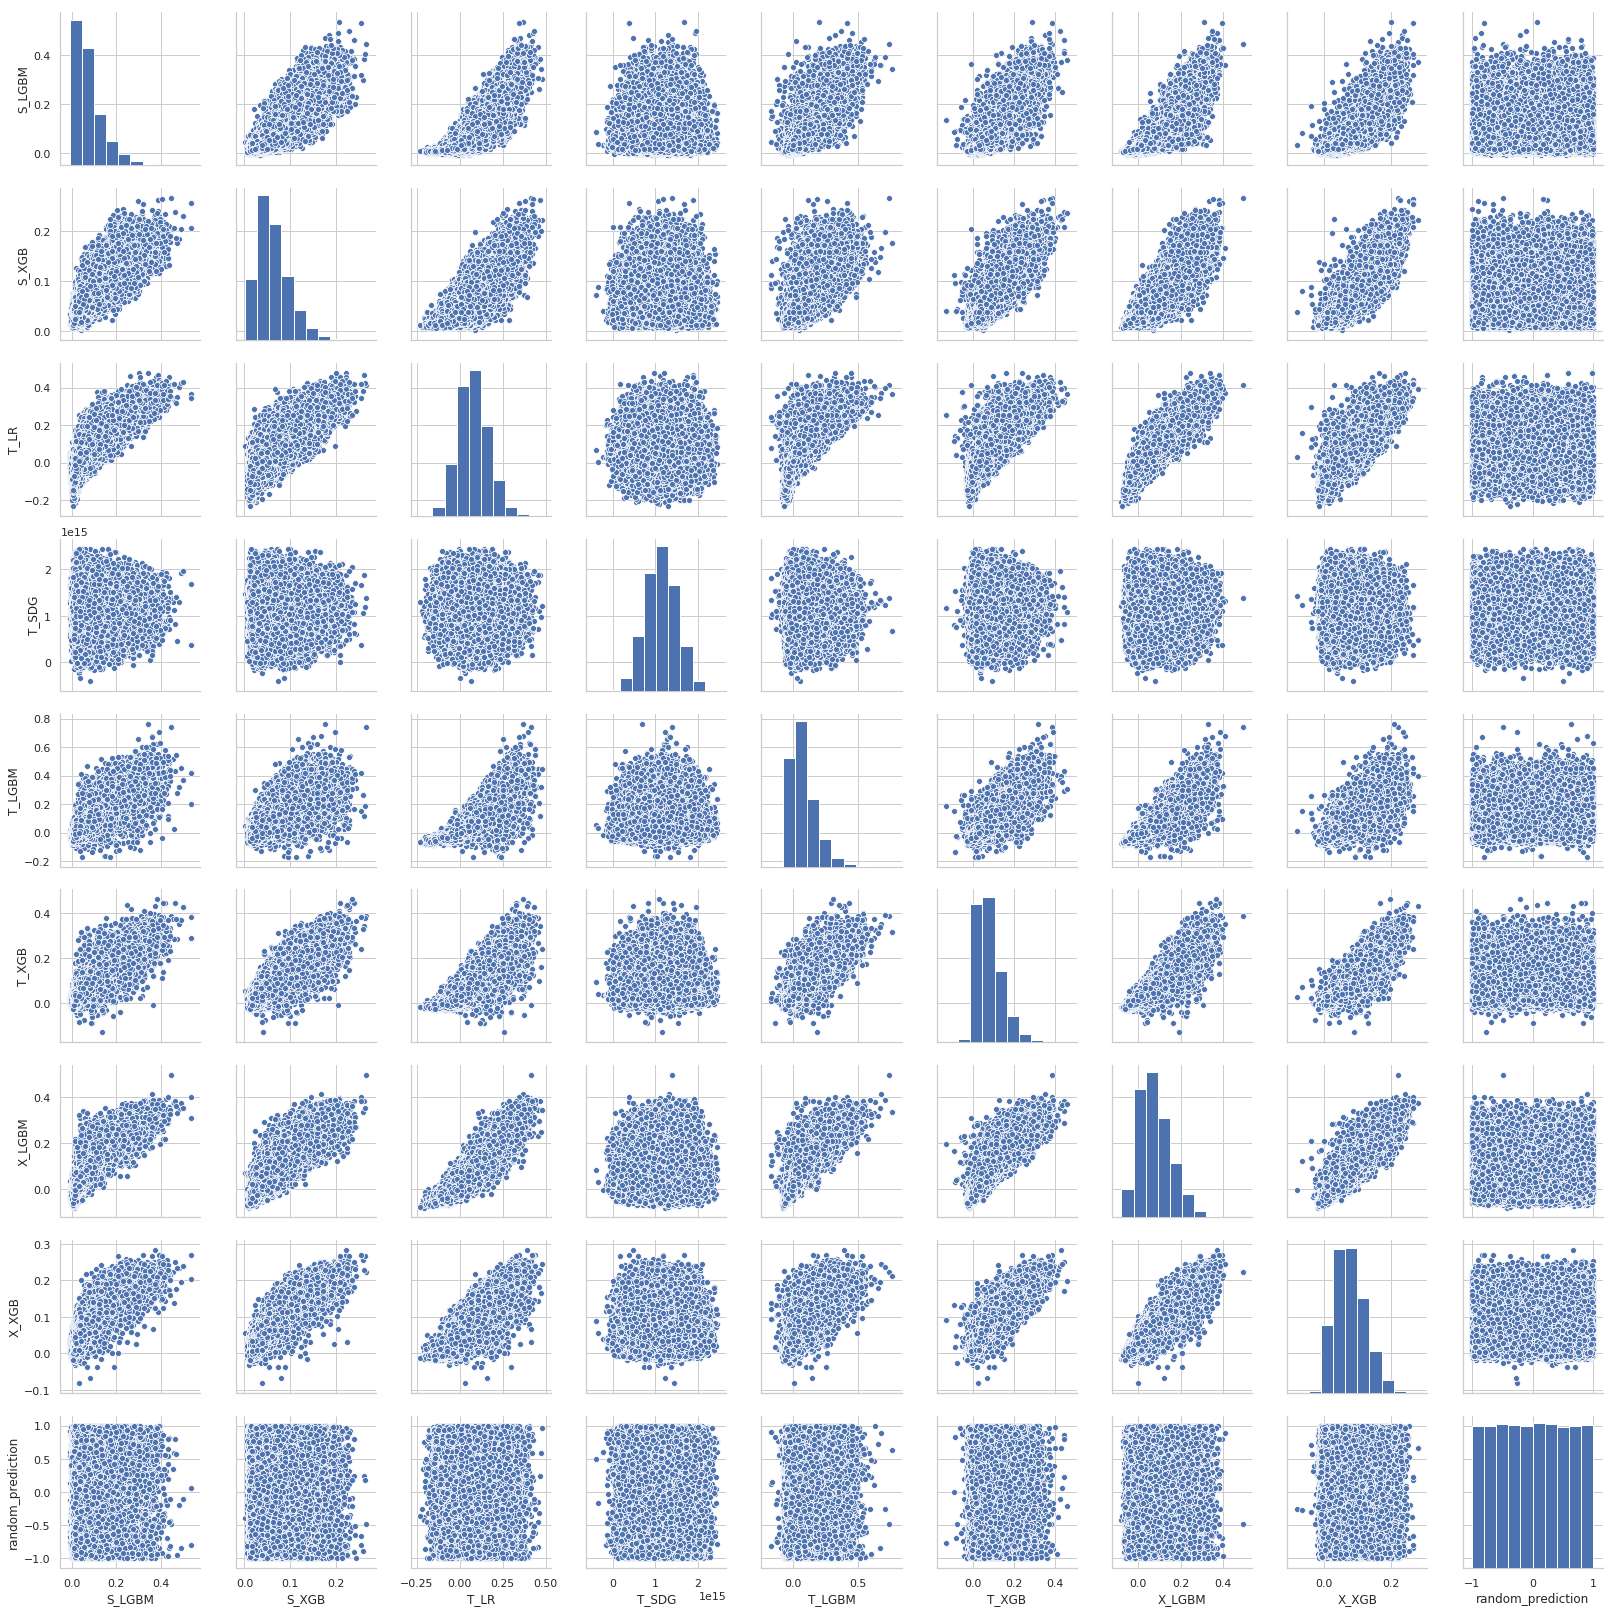

In [7]:
predictions_df = pred_df.iloc[:,-9:]
sns.pairplot(predictions_df);

In [8]:
result_dict = {}
model_list = predictions_df.columns
for i in model_list:
    x = auqc(y_true=pred_df['conversion_post'], uplift=pred_df[i], treatment=pred_df['exposed'])
    result_dict.update({i : x})

In [61]:
pd.DataFrame.from_dict(result_dict, orient='index',columns=['AUQC']).sort_values(by='AUQC', ascending=False)

,AUQC
T_LR,478900315.11
T_LGBM,464116994.03
X_LGBM,460333684.32
S_LGBM,458522408.32
T_XGB,450355063.78
X_XGB,442644227.30
S_XGB,435787604.98
random_prediction,292490251.74
T_SDG,290749753.58


## T Learner LR

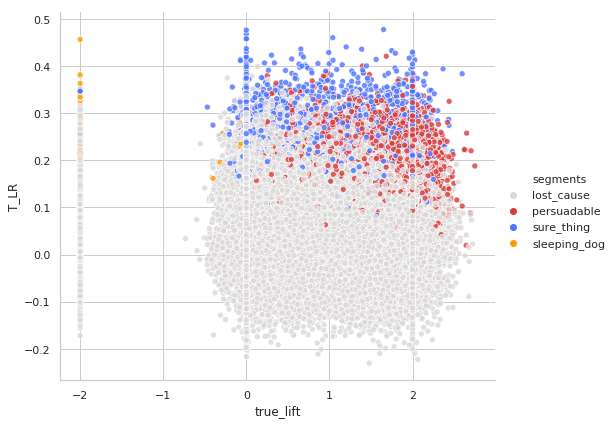

In [10]:
my_pal = {"sure_thing": "#4d73ff", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#ff9d00'}
sns.relplot(x="true_lift", y="T_LR",
            hue="segments",palette=my_pal, data=pred_df, height=6, aspect=1.2, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f44f0a04278>,
      dtype=object)

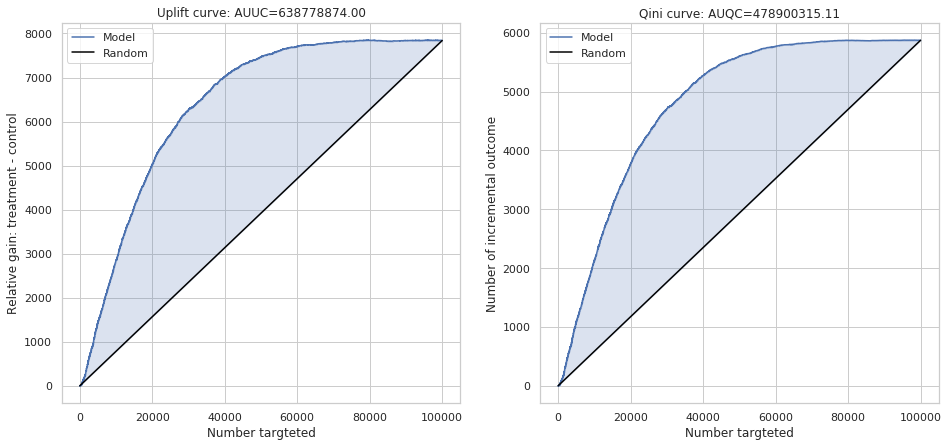

In [11]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['T_LR'], treatment=pred_df['exposed'])

In [14]:
##Assumptions 
budget = 20000 #budget per 100,000 customers
conversion_profit = 500 #Typical profit generated from a sale
cost_per_ad = 4 #cost to treat a customer with an advertisment
treatment_total = int(budget/cost_per_ad)

random_df = pred_df[pred_df["exposed"] == 1].sample(treatment_total, random_state=847)
prediction_df = pred_df[pred_df["exposed"] == 1].sort_values("T_LR",ascending=False).head(treatment_total)

random_p_count = random_df[random_df['segments']=='persuadable']['conversion_post'].sum()
prediction_p_count = prediction_df[prediction_df['segments']=='persuadable']['conversion_post'].sum()
if treatment_total <= pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum():
    perfect_p_count = treatment_total
else:
    perfect_p_count = pred_df[pred_df['segments']=='persuadable']['conversion_post'].sum()
    
    
random_roi = (random_p_count*conversion_profit)- budget
prediction_roi = (prediction_p_count*conversion_profit)- budget
perfect_roi = (perfect_p_count*conversion_profit)- budget
        
print('Treatment Total: {:0,.0f}'.format(treatment_total))
print('Random ROI: ${:0,.0f}'.format(random_roi))
print('Model ROI: ${:0,.0f}'.format(prediction_roi))
print('Perfect ROI: ${:0,.0f}'.format(perfect_roi))

print('Improvement from random: {:.2f}%'.format(((prediction_roi-random_roi)/random_roi)*100))
print('Incremental conversions from random: {}'.format(prediction_p_count-random_p_count))
print('Model to perfect ratio: {:.2f}%'.format((prediction_roi/perfect_roi)*100))

Treatment Total: 5,000
Random ROI: $179,000
Model ROI: $758,500
Perfect ROI: $2,480,000
Improvement from random: 323.74%
Incremental conversions from random: 1159
Model to perfect ratio: 30.58%


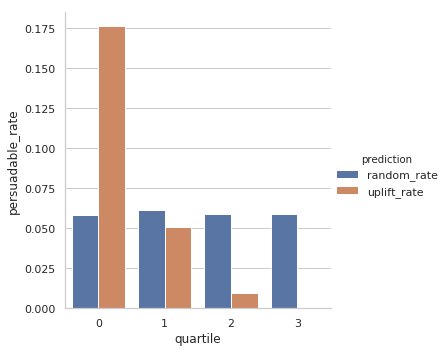

In [13]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['T_LR'] <= pred_df['T_LR'].quantile(q=.75))  & 
                  (pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['T_LR'] <= pred_df['T_LR'].quantile(q=.50))  &
                  (pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['T_LR'] <= pred_df['T_LR'].quantile(q=.25))  &
                  (pred_df['T_LR'] > pred_df['T_LR'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');

## T_LGBM

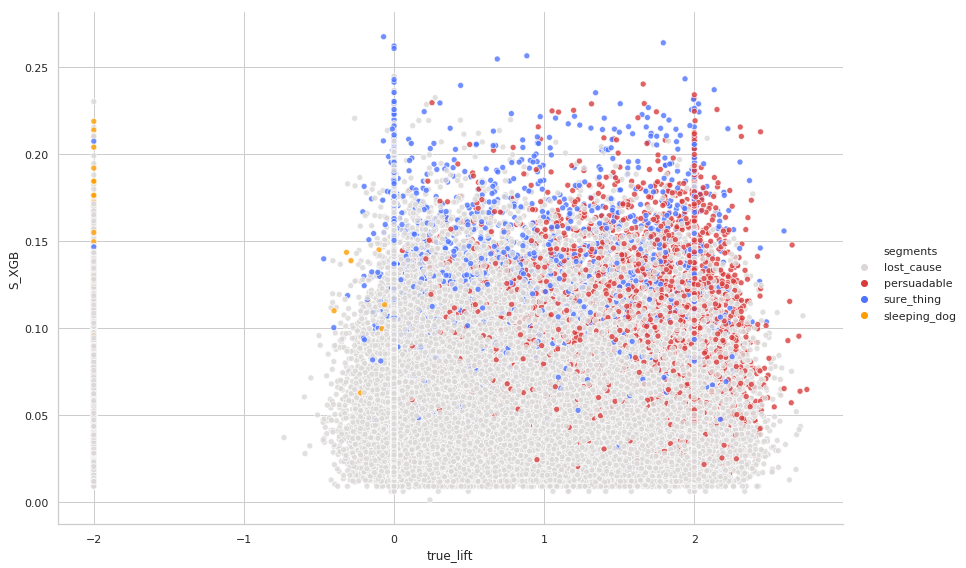

In [17]:
my_pal = {"sure_thing": "#4d73ff", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#ff9d00'}
sns.relplot(x="true_lift", y="S_XGB",
            hue="segments",palette=my_pal, data=pred_df, height=8, aspect=1.5, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fce5c074ba8>,
      dtype=object)

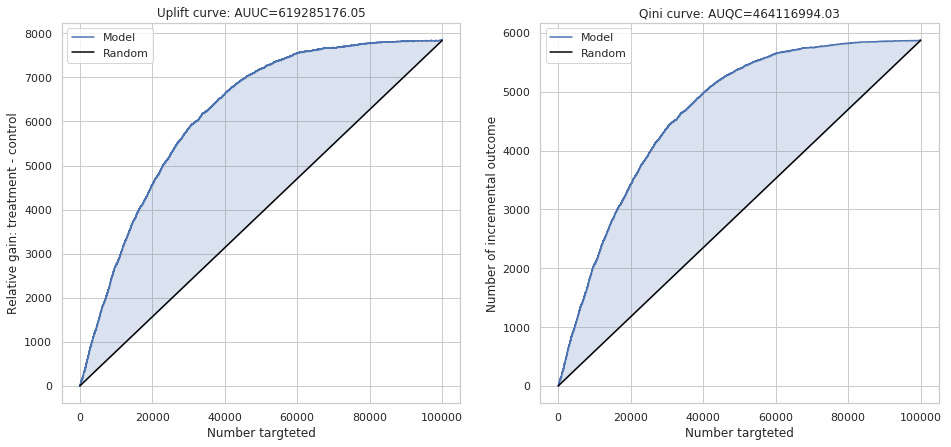

In [67]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['T_LGBM'], treatment=pred_df['exposed'])

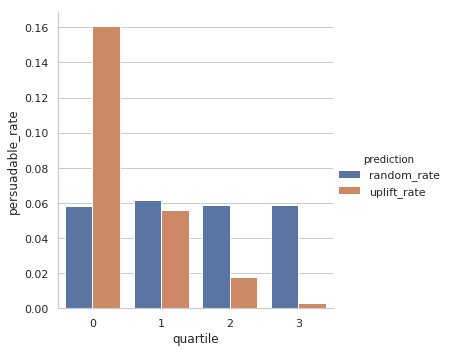

In [68]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['T_LGBM'] > pred_df['T_LGBM'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['T_LGBM'] <= pred_df['T_LGBM'].quantile(q=.75))  & 
                  (pred_df['T_LGBM'] > pred_df['T_LGBM'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['T_LGBM'] <= pred_df['T_LGBM'].quantile(q=.50))  &
                  (pred_df['T_LGBM'] > pred_df['T_LGBM'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['T_LGBM'] <= pred_df['T_LGBM'].quantile(q=.25))  &
                  (pred_df['T_LGBM'] > pred_df['T_LGBM'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');

## random_prediction

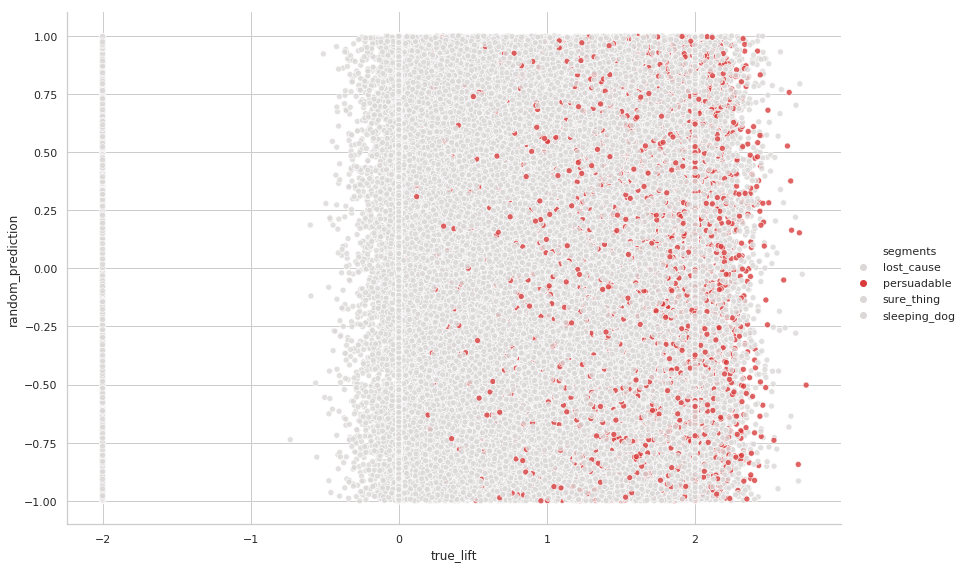

In [69]:
random_predictionmy_pal = {"sure_thing": "#dbd7d7", "lost_cause": "#dbd7d7", "persuadable":"#d93b3b", "sleeping_dog":'#dbd7d7'}
sns.relplot(x="true_lift", y="random_prediction",
            hue="segments",palette=my_pal, data=pred_df, height=8, aspect=1.5, alpha=0.80);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdd9da8f28>,
      dtype=object)

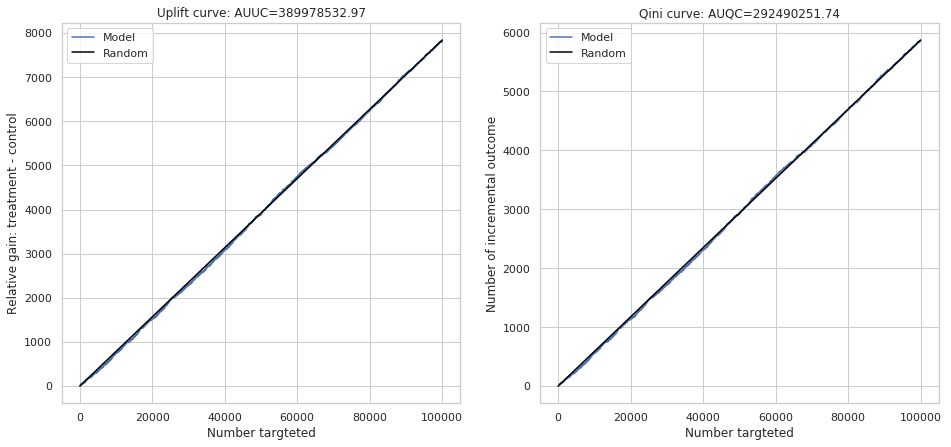

In [70]:
plot_uplift_qini_curves(y_true=pred_df['conversion_post'], uplift=pred_df['random_prediction'], treatment=pred_df['exposed'])

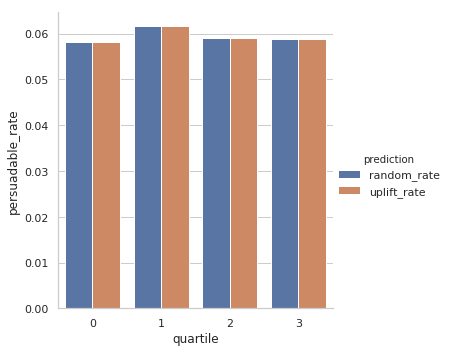

In [71]:
rand1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
rand2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
rand3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
rand4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

rand1_p_count = len(rand1[rand1['segments']=='persuadable'])/len(rand1['segments'])
rand2_p_count = len(rand2[rand2['segments']=='persuadable'])/len(rand2['segments'])
rand3_p_count = len(rand3[rand3['segments']=='persuadable'])/len(rand3['segments'])
rand4_p_count = len(rand4[rand4['segments']=='persuadable'])/len(rand4['segments'])

random_rates = pd.DataFrame([rand1_p_count,rand2_p_count,rand3_p_count,rand4_p_count],columns=['random_rate'])

uplift1 = pred_df[pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.75)]
uplift2 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.75))  & 
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.50))]
uplift3 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.50))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.25))]
uplift4 = pred_df[(pred_df['random_prediction'] <= pred_df['random_prediction'].quantile(q=.25))  &
                  (pred_df['random_prediction'] > pred_df['random_prediction'].quantile(q=.0))]

uplift1_p_count = len(uplift1[uplift1['segments']=='persuadable'])/len(uplift1['segments'])
uplift2_p_count = len(uplift2[uplift2['segments']=='persuadable'])/len(uplift2['segments'])
uplift3_p_count = len(uplift3[uplift3['segments']=='persuadable'])/len(uplift3['segments'])
uplift4_p_count = len(uplift4[uplift4['segments']=='persuadable'])/len(uplift4['segments'])
uplift_rates = pd.DataFrame([uplift1_p_count,uplift2_p_count,uplift3_p_count,uplift4_p_count],columns=['uplift_rate'])

persuade_rate_df = pd.merge(random_rates,uplift_rates, left_index=True, right_index=True)
persuade_rate_df = persuade_rate_df.reset_index()

persuade_rate_df2 = pd.melt(persuade_rate_df, id_vars='index', value_vars=['random_rate','uplift_rate'])

persuade_rate_df2 = persuade_rate_df2.rename(columns={'index':'quartile','value':'persuadable_rate','variable':'prediction'})

sns.catplot(x='quartile', y='persuadable_rate', hue='prediction', data=persuade_rate_df2, kind='bar');